In [1]:
import pandas as pd
df = pd.read_csv('Entrenamieto_ECI_2020.csv',)

def formateo(x):
    cadena = x.split('/')
    return '{dia:02}/{mes:02}/{ano}'.format(dia=int(cadena[0]), mes=int(cadena[1]),ano=int(cadena[2]))
df['Account_Created_Date'] = df['Account_Created_Date'].apply(formateo)
df['Account_Created_Date'] = pd.to_datetime(df['Account_Created_Date'], format='%m/%d/%Y')
df['Planned_Delivery_Start_Date'] = df['Planned_Delivery_Start_Date'].apply(formateo)
df['Planned_Delivery_Start_Date'] = pd.to_datetime(df['Planned_Delivery_Start_Date'], format='%m/%d/%Y')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16947 entries, 0 to 16946
Data columns (total 52 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   ID                                  16947 non-null  int64         
 1   Region                              16947 non-null  object        
 2   Territory                           16947 non-null  object        
 3   Pricing, Delivery_Terms_Quote_Appr  16947 non-null  int64         
 4   Pricing, Delivery_Terms_Approved    16947 non-null  int64         
 5   Bureaucratic_Code_0_Approval        16947 non-null  int64         
 6   Bureaucratic_Code_0_Approved        16947 non-null  int64         
 7   Submitted_for_Approval              16947 non-null  int64         
 8   Bureaucratic_Code                   16947 non-null  object        
 9   Account_Created_Date                16947 non-null  datetime64[ns]
 10  Source                

### ¿Puede deducirse alguna nocion de obsolescencia?

In [2]:
df_producto = df[['Stage','Product_Type','Product_Family','Product_Name','Planned_Delivery_Start_Date','Planned_Delivery_End_Date']]
df_producto = df_producto[df_producto['Stage'] == 'Closed Won']
df_familia = df_producto.groupby('Product_Family')['Planned_Delivery_Start_Date'].agg(['min','max']).reset_index()
df_familia['intervalo'] = df_familia['max'] - df_familia['min']
df_familia[df_familia['intervalo'].dt.days < 365]['intervalo'].count()

96

In [3]:
df_familia[df_familia['intervalo'].dt.days > 365*2.5]['intervalo'].count()

20

Si, se osbserva que de las familias consideradas, la mitad no genera oportunidades exitosas tras
un año de su primera venta. Además solo 20 familias continúan vendiendose tras dos años y medio
desde su publicitación.

In [4]:
df_producto.groupby('Product_Family')['Product_Name'].count().describe()

count    203.000000
mean      46.960591
std      110.781957
min        1.000000
25%        2.000000
50%        8.000000
75%       29.500000
max      919.000000
Name: Product_Name, dtype: float64

### ¿Cuanto es el intervalo promedio de oportunidades por region/territorio?

In [5]:
df_zona = df[['Stage','Region','Territory','Product_Family','Planned_Delivery_Start_Date']]
df_zona_ganada = df_zona[df_zona['Stage'] == 'Closed Won']
df_region = df_zona_ganada.groupby(['Product_Family','Region'])['Planned_Delivery_Start_Date'].agg(['min','max']).reset_index()
df_region['duracion'] = (df_region['max'] - df_region['min']).dt.days
df_region.reset_index().groupby('Region')['duracion'].mean().sort_values()

Region
Middle East     72.923077
Americas       254.805556
APAC           265.125874
EMEA           319.415584
Japan          511.000000
Name: duracion, dtype: float64

In [6]:
df_territorio = df_zona_ganada.groupby(['Product_Family','Territory'])['Planned_Delivery_Start_Date'].agg(['min','max']).reset_index()
df_territorio['duracion'] = (df_region['max'] - df_region['min']).dt.days
df_territorio.reset_index().groupby('Territory')['duracion'].mean().sort_values()

Territory
Turkey               0.000000
Malta                0.000000
South East Asia     10.000000
UAE (Dubai)         14.000000
Slovenia            63.000000
United Kingdom     130.071429
Jordan             151.250000
Philippines        163.000000
Belgium            188.352941
Denmark            188.571429
Sweden             215.500000
India              229.545455
Australia          235.277778
Central US         237.000000
Netherlands        243.904762
Portugal           247.000000
Estonia            251.666667
Indonesia          253.090909
Luxembourg         271.727273
Germany            273.560000
Pakistan           280.000000
SE America         281.571429
France             283.916667
Thailand           299.142857
Singapore          300.250000
China (PRC)        317.500000
Austria            323.818182
Hungary            324.500000
Cyprus             327.000000
Italy              334.941176
Carribean          342.333333
KSA                354.500000
Poland             356.555556


### ¿Cómo es el comportamiento de compra de cada region/territorio?

In [7]:
df_region2 = pd.merge(df_region, df_zona_ganada[['Product_Family','Region','Planned_Delivery_Start_Date']], on=['Product_Family','Region'])
for i in range(0,11):
    df_region2[str(i) + '/10'] = (((df_region2['Planned_Delivery_Start_Date']-df_region2['min']).dt.days)/df_region2['duracion'] >= i/10)\
    & (((df_region2['Planned_Delivery_Start_Date']-df_region2['min']).dt.days)/df_region2['duracion'] < (i+1)/10)
    df_region2[str(i) + '/10'] = df_region2[str(i) + '/10'].astype(int)
df_region2 = df_region2.groupby('Region')[['0/10','1/10','2/10','3/10','4/10','5/10','6/10','7/10','8/10','9/10','10/10']].sum()
df_region2

,0/10,1/10,2/10,3/10,4/10,5/10,6/10,7/10,8/10,9/10,10/10
Region,,,,,,,,,,,
APAC,232,217,216,188,195,225,153,120,110,71,116
Americas,192,202,174,161,220,239,140,147,154,85,63
EMEA,337,274,249,291,292,268,201,191,164,127,57
Japan,354,329,355,466,411,409,375,265,201,90,59
Middle East,14,2,2,0,1,2,0,2,1,0,11


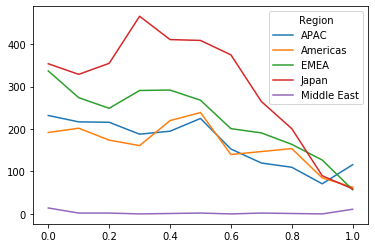

In [8]:
a = df_region2.T
a.index = [0/10,1/10,2/10,3/10,4/10,5/10,6/10,7/10,8/10,9/10,10/10]
a.plot()

In [17]:
df_territorio2 = pd.merge(df_territorio, df_zona_ganada[['Product_Family','Territory','Planned_Delivery_Start_Date']], on=['Product_Family','Territory'])
for i in range(0,11):
    df_territorio2[str(i) + '/10'] = (((df_territorio2['Planned_Delivery_Start_Date']-df_territorio2['min']).dt.days)/df_territorio2['duracion'] >= i/10)\
    & (((df_territorio2['Planned_Delivery_Start_Date']-df_territorio2['min']).dt.days)/df_territorio2['duracion'] < (i+1)/10)
    df_territorio2[str(i) + '/10'] = df_territorio2[str(i) + '/10'].astype(int)
df_territorio2 = df_territorio2.groupby('Territory')[['0/10','1/10','2/10','3/10','4/10','5/10','6/10','7/10','8/10','9/10','10/10']].sum()
df_territorio2

,0/10,1/10,2/10,3/10,4/10,5/10,6/10,7/10,8/10,9/10,10/10
Territory,,,,,,,,,,,
Australia,35,21,13,9,14,20,14,18,0,6,10
Austria,17,10,5,6,5,6,4,1,4,1,0
Belgium,25,4,8,9,3,0,1,0,1,1,0
Bulgaria,0,0,0,0,0,0,0,0,0,0,0
Cambodia,0,0,0,0,0,0,0,0,0,0,0
Canada,3,0,0,0,0,0,0,0,0,0,0
Carribean,2,0,1,0,0,0,1,1,0,0,0
Central US,10,5,2,2,2,0,0,0,0,0,0
China (PRC),5,3,2,3,0,2,0,1,0,2,2


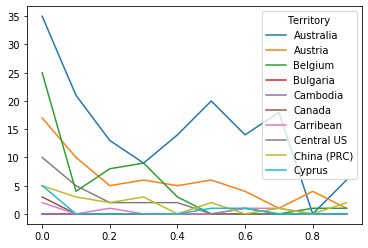

In [22]:
b = df_territorio2.T
b.index = [0/10,1/10,2/10,3/10,4/10,5/10,6/10,7/10,8/10,9/10,10/10]
b.iloc[0:10,0:10].plot()

### ¿Cuales son los clientes con mayor porcentaje de éxito?

In [11]:
df_nombre = df[['Stage','Account_Type','Account_Name','Account_Created_Date']]
df_nombre = df_nombre[(df_nombre['Stage'] == 'Closed Won') | (df_nombre['Stage'] == 'Closed Lost')]
df_por_nombre = df_nombre.groupby('Account_Name')['Stage'].count()
promedio_oportunidades = df_por_nombre.mean()
df_por_nombre = df_por_nombre.to_frame().reset_index()
df_por_nombre = df_por_nombre[df_por_nombre['Stage'] > promedio_oportunidades]
df_por_nombre.columns = ['Account_Name','Total Count']
df_nombre_mejores = df_por_nombre.merge(df_nombre, left_on='Account_Name',right_on='Account_Name',how='left')
def ha_ganado(x):
    if(x == 'Closed Won'):
        return 1
    return 0
df_nombre_mejores['Stage'] = df_nombre_mejores['Stage'].apply(ha_ganado)
mejores_50 = df_nombre_mejores.groupby('Account_Name')['Stage'].mean().nlargest(50).reset_index()
mejores_50.columns = ['Account_Name','Porcentaje_Exito']
mejores_50

,Account_Name,Porcentaje_Exito
0,Account_Name_1240,1.000000
1,Account_Name_147,1.000000
2,Account_Name_1542,1.000000
3,Account_Name_1774,1.000000
4,Account_Name_1784,1.000000
5,Account_Name_231,1.000000
6,Account_Name_993,1.000000
7,Account_Name_591,0.976744
8,Account_Name_1468,0.976190
9,Account_Name_1904,0.967742


### ¿Cuales son los clientes con mayores casos ganados?

In [12]:
df_nombre_mejores.groupby('Account_Name')['Stage'].sum().nlargest(50).reset_index()

,Account_Name,Stage
0,Account_Name_1888,1018
1,Account_Name_1836,795
2,Account_Name_25,539
3,Account_Name_1991,520
4,Account_Name_1508,323
5,Account_Name_1440,267
6,Account_Name_263,205
7,Account_Name_1642,204
8,Account_Name_931,203
9,Account_Name_533,190


### ¿Hay alguna tendencia en la antiguedad del cliente?

In [13]:
df_nombre_mejores.groupby(df_nombre_mejores['Account_Created_Date'].dt.year)['Stage'].mean()

Account_Created_Date
2013    0.734147
2014    0.540954
2015    0.605035
2016    0.640094
2017    0.559250
2018    0.417266
Name: Stage, dtype: float64

Los clientes con mayor antiguedad efectivamente presentan un mayor porcentaje de casos ganados.
Sin embargo no es una relación lineal.

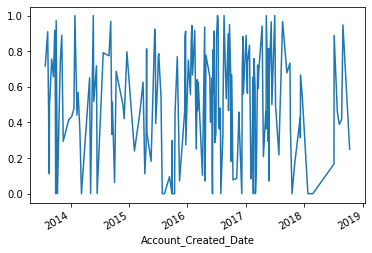

In [14]:
df_nombre_mejores.groupby(df_nombre_mejores['Account_Created_Date'])['Stage'].mean().plot()